# Compute

We oftentimes want to interact with other libraries and have them handle pandas objects.

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 8
pd.options.display.max_columns = 8

We are going to look at some interactions with:

- ``scikit-learn``
- ``statsmodels``
- ``numba`` & ``cython``
- ``dask``

# Scikit-Learn

http://scikit-learn.org/stable/documentation.html

Scikit-Learn's algorithms all deal with numpy arrays. typically:

- data munging in pandas
- pass numpy array to an Estimator
- wrap result in a DataFrame or Series

In [2]:
import sklearn
sklearn.__version__

'0.17'

In [3]:
from sklearn.datasets import california_housing
data = california_housing.fetch_california_housing()

In [4]:
X = pd.DataFrame(data.data, columns=data.feature_names)
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
...,...,...,...,...,...,...,...,...
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24


In [5]:
y = pd.Series(data.target)
y

0        4.526
1        3.585
2        3.521
3        3.413
         ...  
20636    0.771
20637    0.923
20638    0.847
20639    0.894
dtype: float64

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [7]:
%%time
param_grid = dict(
    max_features=np.arange(2, 8),
    max_depth=[2, 4],
    min_samples_split=[5, 10, 15, 20],
)
rfc = RandomForestRegressor(n_estimators=10)
gs = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
gs.fit(X.values, y.values)

CPU times: user 824 ms, sys: 172 ms, total: 996 ms
Wall time: 7.54 s


In [8]:
scores = gs.grid_scores_
scores[:10]

[mean: 0.16860, std: 0.06366, params: {'max_depth': 2, 'max_features': 2, 'min_samples_split': 5},
 mean: 0.19697, std: 0.10137, params: {'max_depth': 2, 'max_features': 2, 'min_samples_split': 10},
 mean: 0.28522, std: 0.07573, params: {'max_depth': 2, 'max_features': 2, 'min_samples_split': 15},
 mean: 0.21689, std: 0.05659, params: {'max_depth': 2, 'max_features': 2, 'min_samples_split': 20},
 mean: 0.31457, std: 0.06943, params: {'max_depth': 2, 'max_features': 3, 'min_samples_split': 5},
 mean: 0.33092, std: 0.08558, params: {'max_depth': 2, 'max_features': 3, 'min_samples_split': 10},
 mean: 0.33806, std: 0.09457, params: {'max_depth': 2, 'max_features': 3, 'min_samples_split': 15},
 mean: 0.36483, std: 0.07498, params: {'max_depth': 2, 'max_features': 3, 'min_samples_split': 20},
 mean: 0.41446, std: 0.06660, params: {'max_depth': 2, 'max_features': 4, 'min_samples_split': 5},
 mean: 0.37167, std: 0.06066, params: {'max_depth': 2, 'max_features': 4, 'min_samples_split': 10}]

In [9]:
def unpack_grid_scores(scores):
    rows = []
    params = sorted(scores[0].parameters)
    for row in scores:
        mean = row.mean_validation_score
        std = row.cv_validation_scores.std()
        rows.append([mean, std] + [row.parameters[k] for k in params])
    return pd.DataFrame(rows, columns=['mean_', 'std_'] + params)

In [10]:
scores = unpack_grid_scores(gs.grid_scores_)
scores

,mean_,std_,max_depth,max_features,min_samples_split
0,0.168600,0.063660,2,2,5
1,0.196974,0.101366,2,2,10
2,0.285216,0.075730,2,2,15
3,0.216886,0.056595,2,2,20
...,...,...,...,...,...
44,0.532177,0.074068,4,7,5
45,0.530026,0.076361,4,7,10
46,0.533337,0.077606,4,7,15
47,0.530026,0.076361,4,7,20


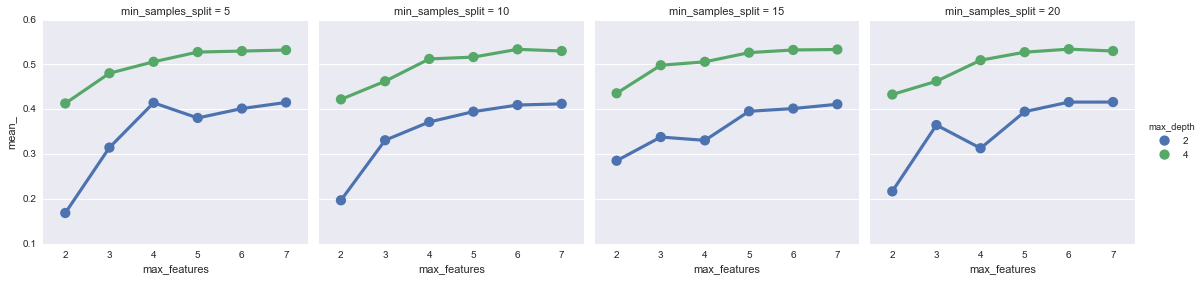

In [11]:
(scores
       .pipe((sns.factorplot,'data'), 
             x='max_features', 
             y='mean_', 
             hue='max_depth', 
             col='min_samples_split')
 )

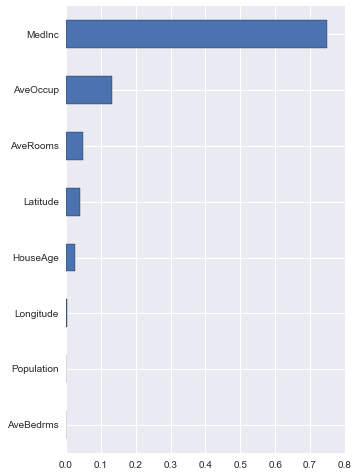

In [12]:
s = pd.Series(gs.best_estimator_.feature_importances_,index=X.columns)
(s.sort_values()
  .plot
  .barh(figsize=(5,8))
)

# Statsmodels

http://statsmodels.sourceforge.net/

In [13]:
import statsmodels
import statsmodels.api as sm
statsmodels.__version__

'0.6.1'

In [57]:
# created in 5. Tidy Data
df = pd.read_hdf('data/games.hdf','df')
df

,date,away_team,away_points,home_team,...,away_strength,home_strength,away_rest,home_rest
game_id,,,,,,,,,
0,2014-10-28 22:30:00,Houston Rockets,108.0,Los Angeles Lakers,...,0.682927,0.256098,NaN,NaN
1,2014-10-28 20:00:00,Orlando Magic,84.0,New Orleans Pelicans,...,0.304878,0.548780,NaN,NaN
2,2014-10-28 20:00:00,Dallas Mavericks,100.0,San Antonio Spurs,...,0.609756,0.670732,NaN,NaN
3,2014-10-29 19:30:00,Brooklyn Nets,105.0,Boston Celtics,...,0.463415,0.487805,NaN,NaN
4,2014-10-29 19:00:00,Milwaukee Bucks,106.0,Charlotte Hornets,...,0.500000,0.402439,NaN,NaN
5,2014-10-29 21:00:00,Detroit Pistons,79.0,Denver Nuggets,...,0.390244,0.365854,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1230,2015-04-15 20:00:00,Boston Celtics,105.0,Milwaukee Bucks,...,0.487805,0.500000,0.0,1.0
1231,2015-04-15 20:00:00,Oklahoma City Thunder,138.0,Minnesota Timberwolves,...,0.548780,0.195122,1.0,1.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 0 to 1235
Data columns (total 10 columns):
date             1230 non-null datetime64[ns]
away_team        1230 non-null object
away_points      1230 non-null float64
home_team        1230 non-null object
home_points      1230 non-null float64
home_win         1236 non-null bool
away_strength    1230 non-null float64
home_strength    1230 non-null float64
away_rest        1217 non-null float64
home_rest        1213 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(6), object(2)
memory usage: 97.8+ KB


In [16]:
df['home_win'] = df.home_win.astype(int)

In [17]:
f ='home_win ~ home_strength + away_strength + home_rest + away_rest'
res = (sm
         .Logit
         .from_formula(f, df)
         .fit()
)

Optimization terminated successfully.
         Current function value: 0.564584
         Iterations 6


In [18]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1213
Model:                          Logit   Df Residuals:                     1208
Method:                           MLE   Df Model:                            4
Date:                Fri, 19 Feb 2016   Pseudo R-squ.:                  0.1727
Time:                        11:08:08   Log-Likelihood:                -684.84
converged:                       True   LL-Null:                       -827.83
                                        LLR p-value:                 1.148e-60
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -0.3254      0.296     -1.098      0.272        -0.906     0.255
home_strength     5.5558      0.449     12.374      0.000         4.676     6.436
away_strength    -4.3365      0.442     -9.817      0.000        -5.202    -3.471
home_rest         0.1215      0.063      1.944      0.052        -0.001     0.244
away_rest        -0.0411      0.061     -0.669      0.503        -0.161     0.079
=================================================================================
"""

In [19]:
df2 = df.assign(rest_difference=df.home_rest - df.away_rest,
                spread=df.home_points - df.away_points)

f = 'spread ~ home_strength + away_strength + rest_difference'
res = (sm
         .OLS
         .from_formula(f, df2)
         .fit()
       )

In [20]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 spread   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     124.6
Date:                Fri, 19 Feb 2016   Prob (F-statistic):           2.57e-70
Time:                        11:08:08   Log-Likelihood:                -4712.1
No. Observations:                1213   AIC:                             9432.
Df Residuals:                    1209   BIC:                             9453.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -0.4035      1.546     -0.261      0.794        -3.437     2.630
home_strength      30.8045      2.097     14.687      0.000        26.689    34.919
away_strength     -25.6003      2.105    -12.159      0.000       -29.731   -21.470
rest_difference     0.5745      0.278      2.064      0.039         0.028     1.121
==============================================================================
Omnibus:                        9.335   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.716
Skew:                           0.099   Prob(JB):                      0.00286
Kurtosis:                       3.438   Cond. No.                         10.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Numba & Cython

http://pandas.pydata.org/pandas-docs/stable/enhancingperf.html

In [21]:
from numba import jit
import cython
%load_ext cython

np.random.seed(1234)
pd.set_option('max_row',12)
s = Series(np.random.randn(1e5))
com = 20.0

/Users/jreback/miniconda/envs/talk/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [22]:
def python(s):
    output = Series(index=range(len(s)))

    alpha = 1. / (1. + com)
    old_weight = 1.0
    new_weight = 1.0
    weighted_avg = s[0]
    output[0] = weighted_avg
    
    for i in range(1,len(s)):
        v = s[i]
        old_weight *= (1-alpha)
        weighted_avg = ((old_weight * weighted_avg) + 
                        (new_weight * v)) / (old_weight + new_weight)
        old_weight += new_weight
        output[i] = weighted_avg
        
    return output

In [23]:
%%cython
cimport cython
@cython.wraparound(False)
@cython.boundscheck(False)
def _cython(double[:] arr, double com, double[:] output):
    cdef:
        double alpha, old_weight, new_weight, weighted_avg, v
        int i
    
    alpha = 1. / (1. + com)
    old_weight = 1.0
    new_weight = 1.0
    weighted_avg = arr[0]
    output[0] = weighted_avg
    
    for i in range(1,arr.shape[0]):
        v = arr[i]
        old_weight *= (1-alpha)
        weighted_avg = ((old_weight * weighted_avg) + 
                        (new_weight * v)) / (old_weight + new_weight)
        old_weight += new_weight
        output[i] = weighted_avg
        
    return output

In [24]:
def cython1(s):
    output = np.empty(len(s),dtype='float64')
    _cython(s.values, com, output)
    return Series(output)

In [42]:
def cython2(s):
    return s.ewm(com=com,adjust=True).mean()

In [38]:
@jit
def _numba(arr, output):
    alpha = 1. / (1. + com)
    old_weight = 1.0
    new_weight = 1.0
    weighted_avg = arr[0]
    output[0] = weighted_avg
    
    for i in range(1,arr.shape[0]):
        v = arr[i]
        old_weight *= (1-alpha)
        weighted_avg = ((old_weight * weighted_avg) + 
                        (new_weight * v)) / (old_weight + new_weight)
        old_weight += new_weight
        output[i] = weighted_avg
    

def numba(s):
 
    output = np.empty(len(s),dtype='float64')
    _numba(s.values, output)
    return Series(output)

In [43]:
result1 = python(s)
result2 = cython1(s)
result3 = cython2(s)
result4 = numba(s)
result1.equals(
    result2) and result1.equals(
    result3) and result1.equals(
    result4)

True

In [44]:
%timeit python(s)

1 loop, best of 3: 1.43 s per loop


In [45]:
%timeit cython1(s)

1000 loops, best of 3: 930 µs per loop


In [46]:
%timeit cython2(s)

100 loops, best of 3: 8.82 ms per loop


In [47]:
%timeit numba(s)

1000 loops, best of 3: 927 µs per loop


# Dask

https://dask.readthedocs.org/en/latest/

In [49]:
import dask.dataframe as dd

In [50]:
np.random.seed(1234)
N = int(1e7)
df = DataFrame({'key' : np.random.randint(0,1000,size=N), 
                'value' : np.random.randn(N)})
ddf = dd.from_pandas(df, npartitions=8)
ddf

dd.DataFrame<from_pandas-6bba1156f06742bbdaf58b9d400597eb, divisions=(0, 1250000, 2500000, ..., 8750000, 9999999)>

In [51]:
%timeit df.groupby('key').value.sum()

1 loop, best of 3: 271 ms per loop


In [52]:
d = ddf.groupby('key').value.sum()
%timeit d.compute()

10 loops, best of 3: 121 ms per loop


In [53]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    d.compute()

[########################################] | 100% Completed |  0.2s


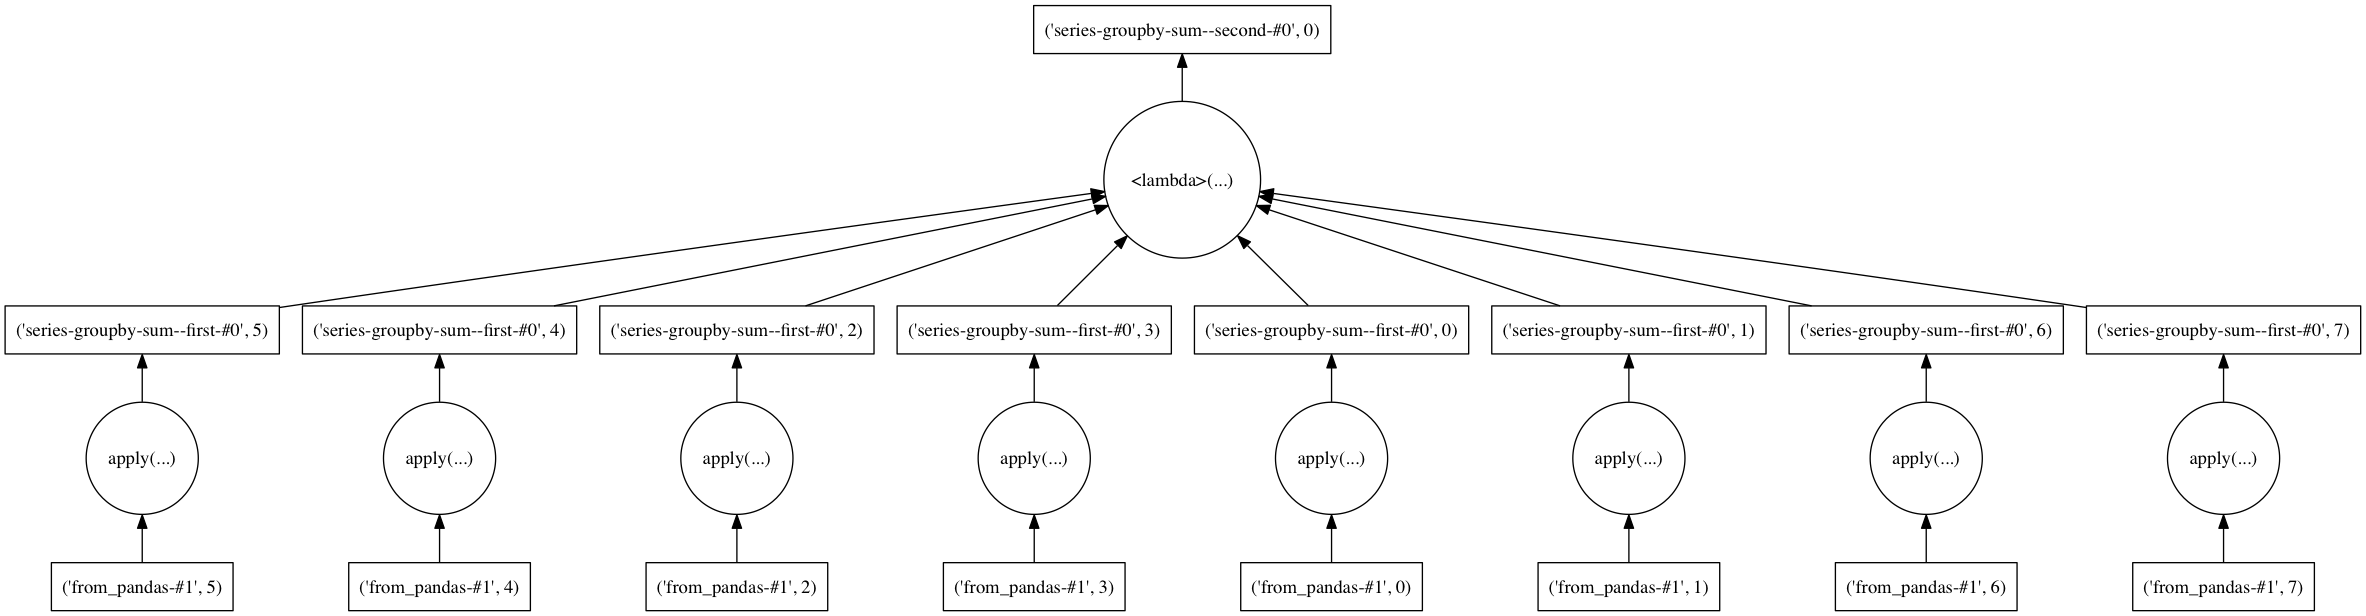

In [54]:
d.visualize()

In [55]:
from dask.diagnostics import Profiler, ResourceProfiler
with Profiler() as prof, ResourceProfiler(dt=0.05) as rprof:
     out = d.compute()

In [56]:
from dask.diagnostics import visualize
from bokeh.io import output_notebook
from bokeh.resources import CDN
output_notebook(CDN, hide_banner=True)
visualize([prof, rprof])